In [ ]:
# ! conda install -c conda-forge ipywidgets

In [1]:
import matplotlib.pyplot as plt
import math
import tensorflow
print(tensorflow.__version__)

2.1.0


In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-medium")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

# Let's chat for 5 lines
# for step in range(5):
#     # encode the new user input, add the eos_token and return a tensor in Pytorch
#     new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

#     # append the new user input tokens to the chat history
#     bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

#     # generated a response while limiting the total chat history to 1000 tokens, 
#     chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)

#     # pretty print last ouput tokens from bot
#     print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

In [ ]:
# Let's chat for 5 lines
for step in range(5):
    # encode the new user input, add the eos_token and return a tensor in Pytorch
    new_user_input_ids = tokenizer.encode(input(">> User:") + tokenizer.eos_token, return_tensors='pt')

    # append the new user input tokens to the chat history
    bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, pad_token_id=tokenizer.eos_token_id)

    # pretty print last ouput tokens from bot
    print("DialoGPT: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], skip_special_tokens=True)))

>> User: Hello


DialoGPT:  swallowing people is not the best idea.


>> User: Hi


DialoGPT:  poking Nazis is not the best idea.


>> User: Are you crazy?


DialoGPT:  in the head, or in the streets?


In [3]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2):

In [3]:
user = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-medium")

In [4]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

# RL test

In [5]:
import math, random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [6]:
# Use CUDA
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

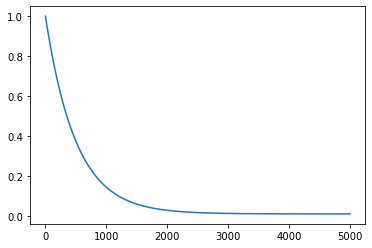

In [7]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
# epsilon_by_frame = lambda frame_idx: max(epsilon_final, epsilon_start*(0.995**frame_idx))
plt.plot([epsilon_by_frame(i) for i in range(5000)])
plt.show()

## Replay Buffer

In [8]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [9]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), requires_grad=False)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

#     q_values      = model(state)
#     next_q_values = model(next_state)

#     q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
#     next_q_value     = next_q_values.max(1)[0]
#     expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
#     for param in model.parameters():
#             param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    return loss

In [10]:
def act(model, state, epsilon):
    if random.random() > epsilon:
        state   = Variable(torch.FloatTensor(state).unsqueeze(0), requires_grad=False)
        q_value = model.forward(state)
        action  = q_value.max(1)[1].item()
    else:
        action = env.action_space.sample()
        #action = random.randrange(env.action_space.n)
    return action

In [11]:
def next_step(action):
    question = user.generate(action, max_length=1000, 
                             pad_token_id=tokenizer.eos_token_id, 
                             num_beams=3,
                             num_return_sequences=2,
                             early_stopping=True,
                             no_repeat_ngram_size=2
                            ) if frame > 0 else chat_history_ids
    
    reward -= jaccard_similarity(answer.numpy(), context.numpy())
    return new_state, reward, False

In [12]:
def decode(token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True)

In [19]:
def discount_rewards(self, r, gamma=0.99):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [230]:
def step_rf(self, args, session, encoder_inputs, decoder_inputs, target_weights,
       bucket_id, rev_vocab=None, debug=True):

    # initialize 
    init_inputs = [encoder_inputs, decoder_inputs, target_weights, bucket_id]
    sent_max_length = args.buckets[-1][0]
    resp_tokens, resp_txt = self.logits2tokens(encoder_inputs, rev_vocab, sent_max_length, reverse=True)
    if debug: print("[INPUT]:", resp_txt)

    # Initialize
    ep_rewards, ep_step_loss, enc_states = [], [], []
    ep_encoder_inputs, ep_target_weights, ep_bucket_id = [], [], []

    # [Episode] per episode = n steps, until break
    while True:
      #----[Step]----------------------------------------
        encoder_state, step_loss, output_logits = self.step(session, encoder_inputs, decoder_inputs, target_weights,
                          bucket_id, training=False, force_dec_input=False)

        # memorize inputs for reproducing curriculum with adjusted losses
        ep_encoder_inputs.append(encoder_inputs)
        ep_target_weights.append(target_weights)
        ep_bucket_id.append(bucket_id)
        ep_step_loss.append(step_loss)
        enc_states_vec = np.reshape(np.squeeze(encoder_state, axis=1), (-1))
        enc_states.append(enc_states_vec)

        # process response
        resp_tokens, resp_txt = self.logits2tokens(output_logits, rev_vocab, sent_max_length)
        if debug: print("[RESP]: (%.4f) %s" % (step_loss, resp_txt))

        # prepare for next dialogue
        bucket_id = min([b for b in range(len(args.buckets)) if args.buckets[b][0] > len(resp_tokens)])
        feed_data = {bucket_id: [(resp_tokens, [])]}
        encoder_inputs, decoder_inputs, target_weights = self.get_batch(feed_data, bucket_id)

        #----[Reward]----------------------------------------
        # r1: Ease of answering
        r1 = [self.logProb(session, args.buckets, resp_tokens, d) for d in self.dummy_dialogs]
        r1 = -np.mean(r1) if r1 else 0

        # r2: Information Flow
        if len(enc_states) < 2:
            r2 = 0
        else:
            vec_a, vec_b = enc_states[-2], enc_states[-1]
            r2 = sum(vec_a*vec_b) / sum(abs(vec_a)*abs(vec_b))
            r2 = -log(r2)

        # r3: Semantic Coherence
        r3 = -self.logProb(session, args.buckets, resp_tokens, ep_encoder_inputs[-1])

        # Episode total reward
        R = 0.25*r1 + 0.25*r2 + 0.5*r3
        rewards.append(R)
        #----------------------------------------------------
        if (resp_txt in self.dummy_dialogs) or (len(resp_tokens) <= 3) or (encoder_inputs in ep_encoder_inputs): 
            break # check if dialog ended

    # gradient decent according to batch rewards
    rto = (max(ep_step_loss) - min(ep_step_loss)) / (max(ep_rewards) - min(ep_rewards))
    advantage = [mp.mean(ep_rewards)*rto] * len(args.buckets)
    _, step_loss, _ = self.step(session, init_inputs[0], init_inputs[1], init_inputs[2], init_inputs[3],
              training=True, force_dec_input=False, advantage=advantage)

    return None, step_loss, None



# log(P(b|a)), the conditional likelyhood
def logProb(self, session, buckets, tokens_a, tokens_b):
    def softmax(x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    # prepare for next dialogue
#     bucket_id = min([b for b in range(len(buckets)) if buckets[b][0] > len(tokens_a)])
#     feed_data = {bucket_id: [(tokens_a, tokens_b)]}
    encoder_inputs, decoder_inputs, target_weights = self.get_batch(feed_data, bucket_id)

    # step
    _, _, output_logits = self.step(session, encoder_inputs, decoder_inputs, target_weights,
                        bucket_id, training=False, force_dec_input=True)

    # p = log(P(b|a)) / N
    p = 1
    for t, logit in zip(tokens_b, output_logits):
        p *= softmax(logit[0])[t]
    p = log(p) / len(tokens_b)
    return p


In [21]:
questions = []
answers = []

In [414]:
chat_history_ids = tokenizer.encode(tokenizer.bos_token + "Hello" + tokenizer.eos_token, return_tensors='pt')

reward = 0
# if USE_CUDA:
#     model = model.cuda()
model.cpu()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
replay_buffer = ReplayBuffer(10000)
batch_size = 64
gamma      = 0.99  # 0.99

for frame in range(2):
    epsilon = epsilon_by_frame(frame)
    # encode the new user input, add the eos_token and return a tensor in Pytorch
#     new_user_input_ids = tokenizer.encode(tokenizer.eos_token, return_tensors='pt')
    question = user.generate(chat_history_ids, max_length=1000, 
                             pad_token_id=tokenizer.eos_token_id, 
                             num_beams=3,
                             num_return_sequences=2,
                             early_stopping=True,
                             no_repeat_ngram_size=2
                            ) if frame > 0 else chat_history_ids
    q = question[:,chat_history_ids.shape[-1]:]
    # append the new user input tokens to the chat history
    bot_input_ids = question # if step > 0 else new_user_input_ids

    # generated a response while limiting the total chat history to 1000 tokens, 
    chat_history_ids = model.generate(bot_input_ids, max_length=1000, 
                                      pad_token_id=tokenizer.eos_token_id,
                                      num_beams=3,
                                      early_stopping=True,
                                      num_return_sequences=2,
                                      no_repeat_ngram_size=2
                                     )
                            

    # pretty print last output tokens from bot
    answer_ids = chat_history_ids[:, bot_input_ids.shape[-1]:]
    a = answer_ids
    context_ids = chat_history_ids[:, :bot_input_ids.shape[-1]]
    answer = chat_history_ids[:, bot_input_ids.shape[-1]:][0]
    context = chat_history_ids[:, :bot_input_ids.shape[-1]][0]
    print("DialoGPT: {}".format(decode(answer)))
    reward -= jaccard_similarity(answer.numpy(), context.numpy())
    
#     state = torch.cat([question, answer_ids], dim=-1)  # add separation token?
#     action = act(model, state, epsilon)
    # next_state, reward, done, _ = next_step(action)
    
    
    
    
    
    
    
    
    
    
#     replay_buffer.push(state, action, reward, next_state, done)
    
    
    
    print(reward)
    print(answer)
    print(context)
#     print(chat_history_ids)
    print(tokenizer.decode(chat_history_ids[0], skip_special_tokens=True))
    


DialoGPT:  Quin scent Quin Quin 211 Quinquin Quin Created Quinectar Quinuding QuinBel Quinsided Quin ot Quinvoc Quin medi Quin entitlement Quin provoked Quin sem Quin eligible Quin Victim Quin Term Quin Assuming Quin Cann Quin Bur Quin adjusts Quin lowers Quin Consent Quin tou Quin disposal Quin grossly Quin accepts Quinahon Quin 314 Quin weed Quin eats Quin Squid QuinDev Quin Con Quin 296 Quin beach Quin totaling Quin Expl Quin Par Quin Je Quin Whereas Quin incorporates Quin Paid Quin dictates Quin kindness Quin Aside Quin murders Quinuploads Quin spills QuinAss Quin 1975 Quin Symptoms Quin Rent Quin Gar Quin Eas Quin Asked Quinitude Quin dolphins Quin prescriptions Quin Casey Quinpod Quin React Quinverts QuinMot Quin Convert Quin exits Quin plague Quin 215 Quin Ind Quin 422 Quin Buffalo Quinrent Quinjection Quin Request Quin Scholars Quin Election Quin slams Quin Salv Quin Brus Quin biting Quin Requ Quin Id Quin attitudes Quin tribes Quin pursuit Quin rocky Quin granted Quinbel Quinv

AssertionError: The context has 1000 number of tokens, but `max_length` is only 1000. Please make sure that `max_length` is bigger than the number of tokens, by setting either `generate(max_length=...,...)` or `config.max_length = ...`

In [9]:
tokenizer.decode(chat_history_ids[0], skip_special_tokens=True)

"Hello!Hello! :DHow are you?I'm good! How are you?Pretty good!That's good!Can you recommend me a movie?I can!Tell meI will!"

In [17]:
chat_history_ids

tensor([[50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        ...,
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ..., 50256, 50256, 50256],
        [50256, 15496, 50256,  ...,   393,  1223, 50256]])

In [22]:
tokenizer.bos_token_id, tokenizer.eos_token_id

50256

In [17]:
a = model.forward(chat_history_ids)
a

(tensor([[[ -1.0835, -18.4458, -17.6662,  ..., -14.8533, -13.5491,   0.9567],
          [ -6.1334, -16.7606, -15.5976,  ..., -10.8078, -10.3935,   1.5186],
          [  6.9852, -10.1889,  -8.7772,  ...,  -6.3700,  -5.0316,   5.8794],
          ...,
          [  5.4960, -10.9813,  -9.6111,  ...,  -6.2588,  -3.6435,   8.3031],
          [ -2.2493, -12.7885, -12.5046,  ...,  -8.5337,  -5.7225,  11.4771],
          [  5.3813, -11.0729,  -9.6908,  ...,  -6.2201,  -3.6808,   8.4822]]],
        grad_fn=<UnsafeViewBackward>),
 (tensor([[[[[ 3.5647e-01,  2.9394e-02,  1.2568e-01,  ..., -5.8864e-01,
              -1.5299e-02, -1.5551e-01],
             [-2.4501e-01, -1.0144e-01,  9.3549e-02,  ..., -3.0358e-01,
              -1.4868e-01,  2.2968e-02],
             [-4.9309e-01, -4.7411e-02,  1.2059e-01,  ..., -2.4241e-01,
              -3.4761e-01, -3.3903e-01],
             ...,
             [-8.7066e-01, -2.2038e-01, -2.6833e-01,  ..., -1.0996e-01,
              -7.4337e-01, -1.9390e-01],
      

In [18]:
a = model(chat_history_ids)

In [45]:
decode(q[1])

'Hello'

In [30]:
import torch.nn.functional as F

In [32]:
# r = answer - context
if len(answer) < 2:
    r2 = 0
else:
    vec_a, vec_b = answer, answer
    r2 = sum(vec_a*vec_b) / sum(abs(vec_a)*abs(vec_b))
    r2 = -F.logsigmoid(r2)

In [34]:
optimizer.zerograd()
r2.backward()

AttributeError: 'Adam' object has no attribute 'zerograd'

In [43]:
q = context_ids

In [46]:
v1 = q[0]
v2 = a[0]

In [47]:
v1,v2

(tensor([50256, 15496, 50256]),
 tensor([10814,   612,  5145, 50256, 50256, 50256]))

In [322]:
from sklearn.metrics.pairwise import cosine_similarity

In [272]:
x = torch.zeros(size=(3,tokenizer.vocab_size))
x[:,-1] = 1
x

tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [290]:
A = model(v1)[0]
B = model(v2)[0]
A,B

(tensor([[103.3320,  96.6074,  96.4836,  ..., 109.7336, 112.1754, 125.7009],
         [107.1582,  98.9198,  98.5507,  ..., 115.2873, 114.8348, 128.2074],
         [116.1806, 104.2458, 106.2476,  ..., 122.1931, 125.4122, 139.5822]],
        grad_fn=<MmBackward>),
 tensor([[ -11.4564,  -17.4578,  -19.1987,  ...,  -16.9864,  -16.7421,
            -7.3800],
         [-206.5140, -198.9877, -200.6138,  ..., -230.4619, -229.1432,
          -207.2097],
         [-180.3867, -184.7284, -181.1404,  ..., -203.2211, -201.3414,
          -167.4208],
         [-157.9265, -160.9077, -163.2302,  ..., -188.6371, -188.0802,
          -162.3012],
         [-200.9722, -208.1657, -210.0039,  ..., -236.2414, -233.3469,
          -213.2841],
         [-179.1016, -196.8122, -194.7751,  ..., -215.5321, -212.9505,
          -185.1048]], grad_fn=<MmBackward>))

In [409]:
model.train()
A = model(v1)[0]
B = model(v2)[0]
max_len = np.max([len(A.detach().numpy()),len(B.detach().numpy())])
print(max_len)
extra = torch.zeros(size=(max_len-len(A.detach().numpy()),tokenizer.vocab_size))
extra[:,-1] = 1
# A = torch.cat([A , extra ])
B = torch.cat((B , torch.tensor([torch.ones(tokenizer.vocab_size)]*(max_len-len(B.detach().numpy()))) ))
A, B

A , B = torch.cat([torch.softmax(A, dim=-1), extra]), torch.softmax(B, dim=-1)
A , B
# loss = F.cosine_similarity(A,B, dim=-2)
loss = -torch.mm(A, B.transpose(1, 0)).sum()

# loss = -F.cosine_similarity(torch.softmax(A, dim=-1),torch.softmax(B, dim=-1))
# loss = 0
# for i,j in zip(v1,v2):
#     loss += i*j
# # loss = -model(v1, past=None)[0].sum()
loss

6


tensor(-0.1308, grad_fn=<NegBackward>)

In [410]:
optimizer.zero_grad()
loss.backward()

In [411]:
optimizer.step()

In [412]:
model.eval()
logits = model(v1)[0]
probs = torch.softmax(logits, dim=-1)
prev_input = torch.multinomial(probs, num_samples=1)
decode(prev_input)

' shore Term marine'

In [413]:
logits

tensor([[75.3702, 73.6392, 72.8180,  ..., 81.0872, 82.3673, 87.0727],
        [74.3895, 72.5374, 71.8523,  ..., 80.4320, 81.0682, 86.7291],
        [73.9969, 72.2922, 71.6807,  ..., 80.3298, 80.4573, 86.1744]],
       grad_fn=<MmBackward>)

In [213]:
model.get_output_embeddings()(model.get_input_embeddings()(v1))

tensor([[ 1.7255, -0.1766,  0.4899,  ...,  1.1379,  1.5983,  6.0774],
        [ 4.2985,  4.3361,  4.6327,  ...,  4.5264,  5.4556,  2.2033],
        [ 1.7255, -0.1766,  0.4899,  ...,  1.1379,  1.5983,  6.0774]],
       grad_fn=<MmBackward>)

In [132]:
model(v1)[0]

tensor([[-122.8433, -150.5232, -149.6123,  ..., -168.9333, -161.6223,
         -133.7793],
        [-204.0837, -205.4568, -208.4964,  ..., -240.3041, -233.0705,
         -217.4363],
        [-205.8837, -210.4453, -214.1883,  ..., -246.4192, -239.3104,
         -219.0015]], grad_fn=<MmBackward>)

In [241]:
tokenizer.padding_side

'right'

TypeError: sequence item 0: expected str instance, NoneType found

In [245]:
tokenizer.convert_tokens_to_ids(['<pad>'])
tokenizer.eos_token_id

[50256]